In [26]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import sympy as sym
plt.style.use('presentation.mplstyle')
%matplotlib notebook

def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item   
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == int:
            numbers += (d[item],)
            dtypes += [(item,int)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)



### Fortescue

In [27]:
alpha = np.exp(2.0/3*np.pi*1j)
A_0a =  np.array([[1, 1, 1],
                  [1, alpha**2, alpha],
                  [1, alpha, alpha**2]])

A_a0 = 1/3* np.array([[1, 1, 1],
                      [1, alpha, alpha**2],
                      [1, alpha**2, alpha]])

### Voltage source

In [54]:
theta = np.deg2rad(20.0)
V_zero =  0.0*np.exp(1j*0.0)
V_neg  = 20.0*np.exp(1j*0.0)
V_pos  =400.0/np.sqrt(3)*np.exp(1j*theta)

V_zpn = np.array([[V_zero],[V_pos],[V_neg]])

V_abc = A_0a @ V_zpn

### Control inputs

In [55]:
L = 500e-6
R = 0.01
omega = 2.0*np.pi*50.0
w = omega
v_dc = 800.0

V_012 = A_a0 @ V_abc 
v_z = V_012[0,0]
v_p = V_012[1,0]
v_n = V_012[2,0]

### PLL

In [56]:
theta_pll = np.angle(v_p)

### Park

In [57]:
v_dq_z = v_z
v_dq_p = v_p*np.exp(-1j*theta_pll)*np.sqrt(2)
v_dq_n = v_n*np.exp( 1j*theta_pll)*np.sqrt(2)

v_d_z = v_dq_z.real # ??
v_q_z = v_dq_z.imag # ??
v_d_p = v_dq_p.imag
v_q_p = v_dq_p.real
v_d_n = v_dq_n.imag
v_q_n = v_dq_n.real

### References

In [85]:
p_ref = 0.6e6
q_ref = 0.2e6

pq_ref = np.array([p_ref,q_ref,0,0]).reshape(4,1)
i2p=3/2*np.array([[ v_d_p, v_q_p, v_d_n, v_q_n],  # i_d_p
                  [-v_q_p, v_d_p,-v_q_n, v_d_n],  # i_q_p
                  [-v_q_n, v_d_n, v_q_p,-v_d_p],  # i_d_n
                  [ v_d_n, v_q_n, v_d_p, v_q_p]]) # i_q_n


p2i=np.linalg.inv(i2p)

i_dq_pn = p2i@pq_ref

i_d_p_ref = 100.0
i_q_p_ref = 0.0
i_d_n_ref = 0.0
i_q_n_ref = 0.0

i_d_p_ref = i_dq_pn[0,0]
i_q_p_ref = i_dq_pn[1,0]
i_d_n_ref = i_dq_pn[2,0]
i_q_n_ref = i_dq_pn[3,0]

mode = 'p_cte'

if mode == 'p_pos_i_n_0':
    i_d_p_ref = -(0.666666666666667*p_ref*v_d_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + 0.666666666666667*q_ref*v_q_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_p_ref = 0.666666666666667*(-p_ref*v_q_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + q_ref*v_d_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_d_n_ref = 0
    i_q_n_ref = 0
    
if mode == 'q_cte':
    i_d_p_ref = 0.666666666666667*(p_ref*v_d_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) + q_ref*v_q_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_p_ref = 0.666666666666667*(p_ref*v_q_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) - q_ref*v_d_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_d_n_ref = 0.666666666666667*(p_ref*v_d_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) - q_ref*v_q_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_n_ref = 0.666666666666667*(p_ref*v_q_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) + q_ref*v_d_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)    

if mode == 'pq_cte': # Lipo
    i_d_p_ref = 0.666666666666667*(-p_ref*v_d_p + q_ref*v_q_p)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
    i_q_p_ref = -(0.666666666666667*p_ref*v_q_p + 0.666666666666667*q_ref*v_d_p)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
    i_d_n_ref = 0.666666666666667*(p_ref*v_d_n + q_ref*v_q_n)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
    i_q_n_ref = 0.666666666666667*(p_ref*v_q_n - q_ref*v_d_n)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)

if mode == 'p_cte':
    i_d_p_ref = -(0.666666666666667*p_ref*v_d_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + 0.666666666666667*q_ref*v_q_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_p_ref = 0.666666666666667*(-p_ref*v_q_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + q_ref*v_d_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_d_n_ref = 0.666666666666667*(p_ref*v_d_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) - q_ref*v_q_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_n_ref = 0.666666666666667*(p_ref*v_q_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + q_ref*v_d_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)

if mode == 'z_mode':
    I_p_ref = np.conj((p_ref+1j*q_ref)/v_p)/3/np.sqrt(3)
    Z_p = v_p/I_p_ref
    I_n_ref = np.conj((p_ref+1j*q_ref)/v_n)/3/np.sqrt(3)
    Z_n = v_n/I_n_ref
    i_d_p_ref = ((v_q_p + 1j*v_d_p)/Z_p).imag
    i_q_p_ref = ((v_q_p + 1j*v_d_p)/Z_p).real
    i_d_n_ref = ((v_q_n + 1j*v_d_n)/Z_n).imag
    i_q_n_ref = ((v_q_n + 1j*v_d_n)/Z_n).real



### Control

In [86]:
#L*did = e_d - R*i_d - w*L*i_q - v_d
#L*diq = e_q - R*i_q + w*L*i_d - v_q

eta_d_p = 2.0/v_dc*(R*i_d_p_ref + L*w*i_q_p_ref + v_d_p)
eta_q_p = 2.0/v_dc*(R*i_q_p_ref - L*w*i_d_p_ref + v_q_p)
eta_d_n = 2.0/v_dc*(R*i_d_n_ref + L*w*i_q_n_ref + v_d_n)
eta_q_n = 2.0/v_dc*(R*i_q_n_ref - L*w*i_d_n_ref + v_q_n)

eta_dq_p = eta_q_p + 1j*eta_d_p
e_dq_p = v_dc/2.0*eta_dq_p       # phase-neutral peak value
 
eta_dq_n = eta_q_n + 1j*eta_d_n
e_dq_n = v_dc/2.0*eta_dq_n       # phase-neutral peak value

### Modulation

In [87]:
e_p = e_dq_p *np.exp( 1j*theta_pll)/np.sqrt(2) # phase-neutral RMS value   
e_n = e_dq_n *np.exp(-1j*theta_pll)/np.sqrt(2) # phase-neutral RMS value
e_z = 0.0
#e_n = 0.0

e_012 = np.array([e_z,e_p,e_n]).reshape(3,1)
e_abc = A_0a @ e_012 

### Plant

In [88]:
Z_1 = R +1j *L*omega
Z_2 = Z_1
Z_0 = Z_1

Z_012 = np.diag([Z_0,Z_1,Z_2])

Z_abc = A_0a @ Z_012 @ A_a0

Y_abc = np.linalg.inv(Z_abc)
I_abc = Y_abc @ (e_abc-V_abc)

I_abc

array([[ 842.37826331  +4.37596529j],
       [-374.42050632-862.59440972j],
       [-467.95775699+858.21844443j]])

In [89]:
V_abc.T @ np.conj(I_abc)

array([[ 600000.+200000.j]])

In [90]:
I_012 = A_a0 @ I_abc 
i_dq_z_out = I_012[0] ## ???
i_dq_p_out = I_012[1]*np.exp(-1j*theta_pll)*np.sqrt(2)
i_dq_n_out = I_012[2]*np.exp( 1j*theta_pll)*np.sqrt(2)

i_d_p = i_dq_p_out.imag
i_q_p = i_dq_p_out.real
i_d_n = i_dq_n_out.imag
i_q_n = i_dq_n_out.real

print(i_d_p_ref,i_d_p)
print(i_q_p_ref,i_q_p)
print(i_d_n_ref,i_d_n)
print(i_q_n_ref,i_q_n)


-405.209221304 [-405.2092213]
1233.99987042 [ 1233.99987042]
-69.5266782161 [-69.52667822]
-88.4204018619 [-88.42040186]


## Fisix

In [91]:
p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref = 1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n
q_cte_ref = -1.5*i_d_n*v_q_n - 1.5*i_d_p*v_q_p + 1.5*i_q_n*v_d_n + 1.5*i_q_p*v_d_p
q_cos_ref = -1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p - 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p - 1.5*i_q_p*v_q_n


lhs = ['p_cte_ref','p_cos_ref','p_sin_ref','q_cte_ref','q_cos_ref','q_sin_ref']
rhs = [p_cte_ref,p_cos_ref,p_sin_ref,q_cte_ref,q_cos_ref,q_sin_ref]
for lh,rh in zip(lhs,rhs):
    print('{:s}_ref = {:s}'.format(str(lh) ,str(sym.simplify(rh))))

p_cte_ref_ref = 600000.000000000
p_cos_ref_ref = 1.89174897968769e-10
p_sin_ref_ref = -1.45519152283669e-10
q_cte_ref_ref = 200000.000000000
q_cos_ref_ref = 68121.9540560626
q_sin_ref_ref = -86633.9469654326


### From phasor to time

In [92]:
t = np.linspace(0.0,0.04-0.04/1000,1000)

v_a = (np.exp(1j*w*t)*V_abc[0]).real*np.sqrt(2)
v_b = (np.exp(1j*w*t)*V_abc[1]).real*np.sqrt(2)
v_c = (np.exp(1j*w*t)*V_abc[2]).real*np.sqrt(2)
i_a = (np.exp(1j*w*t)*I_abc[0]).real*np.sqrt(2)
i_b = (np.exp(1j*w*t)*I_abc[1]).real*np.sqrt(2)
i_c = (np.exp(1j*w*t)*I_abc[2]).real*np.sqrt(2)
v_a_p = (np.exp(1j*(w*t-np.pi/2))*V_abc[0]).real*np.sqrt(2)
v_b_p = (np.exp(1j*(w*t-np.pi/2))*V_abc[1]).real*np.sqrt(2)
v_c_p = (np.exp(1j*(w*t-np.pi/2))*V_abc[2]).real*np.sqrt(2)
#i_a = i_a_p + i_a_n
#i_b = i_c_p + i_c_n
#i_c = i_b_p + i_b_n

p = v_a*i_a + v_b*i_b + v_c*i_c
q = (i_a*(v_b-v_c) + i_b*(v_c-v_a) + i_c*(v_a-v_b))/np.sqrt(3)
q_lipo = v_a_p*i_a + v_b_p*i_b + v_c_p*i_c
#q = (i_a*(v_c-v_b) + i_b*(v_a-v_c) + i_c*(v_b-v_a))/np.sqrt(3)

In [93]:
I_abc

array([[ 842.37826331  +4.37596529j],
       [-374.42050632-862.59440972j],
       [-467.95775699+858.21844443j]])

In [94]:
I_zpn = A_a0 @ I_abc
V_zpn = A_a0 @ V_abc

I_p = I_zpn[1]
I_n = I_zpn[2]
V_p = V_zpn[1]
V_n = V_zpn[2]

w = 2.0*np.pi*50.0

i_alpha_p = (np.exp( 1j*w*t)*I_p).imag*np.sqrt(2)
i_beta_p  = (np.exp( 1j*w*t)*I_p).real*np.sqrt(2)
i_alpha_n = (np.exp(-1j*w*t)*I_n).imag*np.sqrt(2)
i_beta_n  = (np.exp(-1j*w*t)*I_n).real*np.sqrt(2)

v_alpha_p = (np.exp( 1j*w*t)*V_p).imag*np.sqrt(2)
v_beta_p  = (np.exp( 1j*w*t)*V_p).real*np.sqrt(2)
v_alpha_n = (np.exp(-1j*w*t)*V_n).imag*np.sqrt(2)
v_beta_n  = (np.exp(-1j*w*t)*V_n).real*np.sqrt(2)

v_alpha_p_lipo = (-1j*np.exp( 1j*w*t)*V_p).imag*np.sqrt(2)
v_beta_p_lipo  = (-1j*np.exp( 1j*w*t)*V_p).real*np.sqrt(2)
v_alpha_n_lipo = (1j*np.exp(-1j*w*t)*V_n).imag*np.sqrt(2)
v_beta_n_lipo  = (1j*np.exp(-1j*w*t)*V_n).real*np.sqrt(2)

i_alpha = i_alpha_p + i_alpha_n
i_beta  = i_beta_p + i_beta_n
v_alpha = v_alpha_p + v_alpha_n
v_beta  = v_beta_p + v_beta_n
v_alpha_lipo = v_alpha_p_lipo + v_alpha_n_lipo
v_beta_lipo  = v_beta_p_lipo + v_beta_n_lipo
#Clark = 2/3*[[1/np.sqrt(2),1/np.sqrt(2),1/np.sqrt(2)],
#             [1,-0.5,-0.5]
#             [0,-np.sqrt(3)/2,np.sqrt(3)/2]]

#i_oab = np.array([0.0,i_alpha,i_beta])
#v_oab = np.array([0.0,v_alpha,v_beta])
inv_Clark=np.linalg.inv(Clark)
def oab2abc(alpha,beta):
    N_t = len(alpha)
    abc = np.zeros((3,N_t))
    for it in range():
        abc[:,it] = Clark
#for 
#v_abc = np.lianlg.solve(Clark,v_oab)

p = 3/2*(i_alpha*v_alpha + i_beta*v_beta)
q = 3/2*(v_alpha*i_beta - v_beta*i_alpha)
q_lipo = 3/2*(i_alpha*v_alpha_lipo + i_beta*v_beta_lipo)

<IPython.core.display.Javascript object>


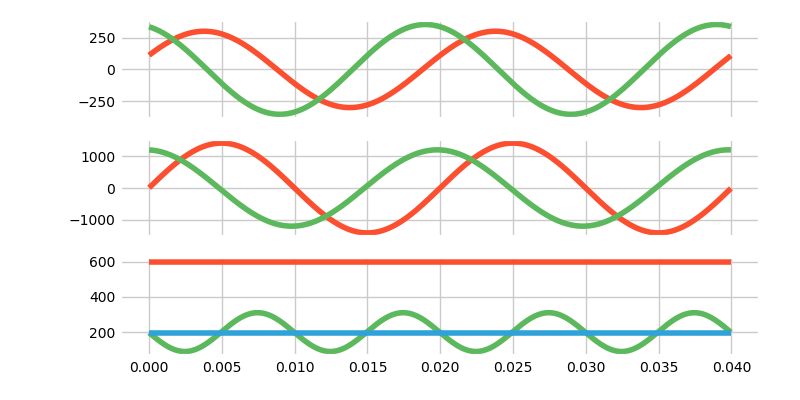

p =  600000.0
q =  200000.0
q_lipo =  197022.332506
i_alpha_max =  1405.03781184
i_beta_max =  1193.74749139


In [95]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 4), sharex = True)

axes[0].plot(t, v_alpha)
axes[0].plot(t, v_beta)

axes[1].plot(t, i_alpha)
axes[1].plot(t, i_beta)

axes[2].plot(t, p/1000)
axes[2].plot(t, q/1000)
axes[2].plot(t, q_lipo/1000)

print('p = ',np.average(p))
print('q = ',np.average(q))
print('q_lipo = ',np.average(q_lipo))

print('i_alpha_max = ',np.max(abs(i_alpha)))
print('i_beta_max = ',np.max(abs(i_beta)))

0.5714285714285714

### Reference following check

In [685]:
I_012 = A_a0 @ I_abc 
i_dq_z_out = I_012[0]*np.exp(-1j*theta_pll)*np.sqrt(2)
i_dq_p_out = I_012[1]*np.exp(-1j*theta_pll)*np.sqrt(2)
i_dq_n_out = I_012[2]*np.exp(-1j*theta_pll)*np.sqrt(2)

i_d_p = i_dq_p_out.imag
i_q_p = i_dq_p_out.real
i_d_n = i_dq_n_out.imag
i_q_n = i_dq_n_out.real

print(i_d_p_ref,i_dq_p_out.real)
print(i_q_p_ref,i_dq_p_out.imag)
print(i_d_n_ref,i_dq_n_out.real)
print(i_q_n_ref,i_dq_n_out.imag)

p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref =-1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_cte_ref = 1.5*i_d_n*v_q_n + 1.5*i_d_p*v_q_p - 1.5*i_q_n*v_d_n - 1.5*i_q_p*v_d_p
q_cos_ref = 1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p - 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p - 1.5*i_q_p*v_q_n

# Lipo
p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref = -1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_cte_ref = -1.5*i_d_n*v_q_n + 1.5*i_d_p*v_q_p + 1.5*i_q_n*v_d_n - 1.5*i_q_p*v_d_p
q_cos_ref = 1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n

lhs = ['p_cte_ref','p_cos_ref','p_sin_ref','q_cte_ref','q_cos_ref','q_sin_ref']
rhs = [p_cte_ref,p_cos_ref,p_sin_ref,q_cte_ref,q_cos_ref,q_sin_ref]
for lh,rh in zip(lhs,rhs):
    print('{:s}_ref = {:s}'.format(str(lh) ,str(sym.simplify(rh))))


-1632.99316186 [ 4082.48290464]
4082.48290464 [-1632.99316186]
-2538.14986202 [-3806.00464724]
-2838.62559665 [-119.70223554]
p_cte_ref_ref = 465260.769509609
p_cos_ref_ref = -473917.012361638
p_sin_ref_ref = -1184792.53090409
q_cte_ref_ref = -1304554.74865842
q_cos_ref_ref = 1184792.53090409
q_sin_ref_ref = -473917.012361638


### Positive sequence calculation

In [137]:
Z = R +1j *L*omega
I_pos = (e_p - v_p)/Z
I_pos

(757.18068090442762-4.5051966725939852e-13j)

In [138]:
S  =V_abc.T @ np.conj(I_abc)
S

array([[ 500000. +2.04844920e-08j]])

In [139]:
I_012 = A_a0 @ I_abc 
I_012*np.sqrt(2)

array([[ -6.02915504e-14 -8.03887339e-14j],
       [  1.07081519e+03 -4.82834833e-11j],
       [ -2.31838289e+02 +2.77743076e-11j]])

In [140]:
import sympy as sym

In [141]:
v_d_p,v_q_p,v_d_n,v_q_n = sym.symbols('v_d_p,v_q_p,v_d_n,v_q_n')

i2p = sym.Matrix([[ v_d_p, v_q_p, v_d_n, v_q_n],
                  [-v_q_p, v_d_p,-v_q_n, v_d_n],
                  [-v_q_n, v_d_n, v_q_p,-v_d_p],
                  [ v_d_n, v_q_n, v_d_p, v_q_p]])


p2i = sym.simplify(i2p.inv())

In [142]:
sym.simplify(p2i)

Matrix([
[-v_d_p/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2), -v_q_p/(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2), (-v_d_n**2*v_q_n + 2*v_d_n*v_d_p*v_q_p - v_d_p**2*v_q_n - v_q_n**3 + v_q_n*v_q_p**2)/(v_d_n**4 + 2*v_d_n**2*v_q_n**2 - v_d_p**4 - 2*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4),  (v_d_n**3 + v_d_n*v_d_p**2 + v_d_n*v_q_n**2 - v_d_n*v_q_p**2 + 2*v_d_p*v_q_n*v_q_p)/(v_d_n**4 + 2*v_d_n**2*v_q_n**2 - v_d_p**4 - 2*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)],
[-v_q_p/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2),  v_d_p/(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2),  (v_d_n**3 - v_d_n*v_d_p**2 + v_d_n*v_q_n**2 + v_d_n*v_q_p**2 - 2*v_d_p*v_q_n*v_q_p)/(v_d_n**4 + 2*v_d_n**2*v_q_n**2 - v_d_p**4 - 2*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4),  (v_d_n**2*v_q_n + 2*v_d_n*v_d_p*v_q_p - v_d_p**2*v_q_n + v_q_n**3 + v_q_n*v_q_p**2)/(v_d_n**4 + 2*v_d_n**2*v_q_n**2 - v_d_p**4 - 2*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)],
[ v_d_n/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2), -v_q_n/(v_d_n**2 + v_d_p**2 + 

In [143]:
theta = np.deg2rad(0.0)
phi = np.deg2rad(90.0)
V_zero =  0.0*np.exp(1j*0.0)
V_neg  =100.0*np.exp(1j*0.0)
V_pos  =231.0*np.exp(1j*theta)

V_012 = np.array([[V_zero],[V_pos],[V_neg]])

V_abc = A_0a @ V_012

I_zero =   0.0*np.exp(1j*0.0)
I_neg  =   0.0*np.exp(1j*(theta+phi))
I_pos  = 10.0*np.exp(1j*(theta-phi))

s_012 = 500e3
sin_012 = 0.0
cos_012 = 0.0
I_pos = (V_neg*sin_012 - V_pos*s_012)/(3*(V_neg**2 - V_pos**2))
I_neg = (V_neg*s_012 - V_pos*sin_012)/(3*(V_neg**2 - V_pos**2))

#I_pos = (-V_neg*sin_012 + V_pos*s_012)/(3*(V_neg**2 + V_pos**2))
#I_neg = ( V_neg*s_012 + V_pos*sin_012)/(3*(V_neg**2 + V_pos**2))
#I = 1j
#I_pos = 0.333333333333333*(V_neg*sin_012 - V_pos*s_012*(1.0 + I))/(V_neg**2*(1.0 - I) - V_pos**2*(1.0 + I))
#I_neg = 0.333333333333333*(V_neg*s_012*(1.0 - I) - V_pos*sin_012)/(V_neg**2*(1.0 - I) - V_pos**2*(1.0 + I))

#I_pos = 0.333333333333333*(V_neg*sin_012 - V_pos*s_012*(1.0 - I))/(V_neg**2*(1.0 + I) - V_pos**2*(1.0 - I))
#I_neg = 0.333333333333333*(V_neg*s_012*(1.0 + I) - V_pos*sin_012)/(V_neg**2*(1.0 + I) - V_pos**2*(1.0 - I))

#I_pos = 0.333333333333333*(I*V_neg*cos_012 + V_pos*s_012)/(V_neg**2 + V_pos**2)
#I_neg = 0.333333333333333*(V_neg*s_012 - I*V_pos*cos_012)/(V_neg**2 + V_pos**2)

#I_pos= (0.166666666666667 - 0.166666666666667*I)*(V_neg*(cos_012 + sin_012) - V_pos*s_012*(1.0 + I))/(V_neg**2 - V_pos**2)
#I_neg= (0.166666666666667 - 0.166666666666667*I)*(V_neg*s_012*(1.0 + I) - V_pos*(cos_012 + sin_012))/(V_neg**2 - V_pos**2)

#I_neg = (cos_012 + sin_012)/(6*V_pos)
#I_pos = (-V_neg*(cos_012 + sin_012) + 2*V_pos*s_012)/(6*V_pos**2)
I_pos = np.conj(s_012/(3*V_pos))
I_neg = -V_neg*I_pos/(V_pos)

I_012 = np.array([[I_zero],[I_pos],[I_neg]])

I_abc = A_0a @ I_012


In [144]:
v_abc = (np.exp(1j*2.0*np.pi*50.0*t)*V_abc).real*np.sqrt(2)
i_abc = (np.exp(1j*2.0*np.pi*50.0*t)*I_abc).real*np.sqrt(2)

p = np.sum(v_abc * i_abc, axis=0)
q = -((v_abc[1]- v_abc[2]) * i_abc[0] + (v_abc[2]- v_abc[0]) * i_abc[1]  + (v_abc[0]- v_abc[1]) * i_abc[2] )/np.sqrt(3)

<IPython.core.display.Javascript object>


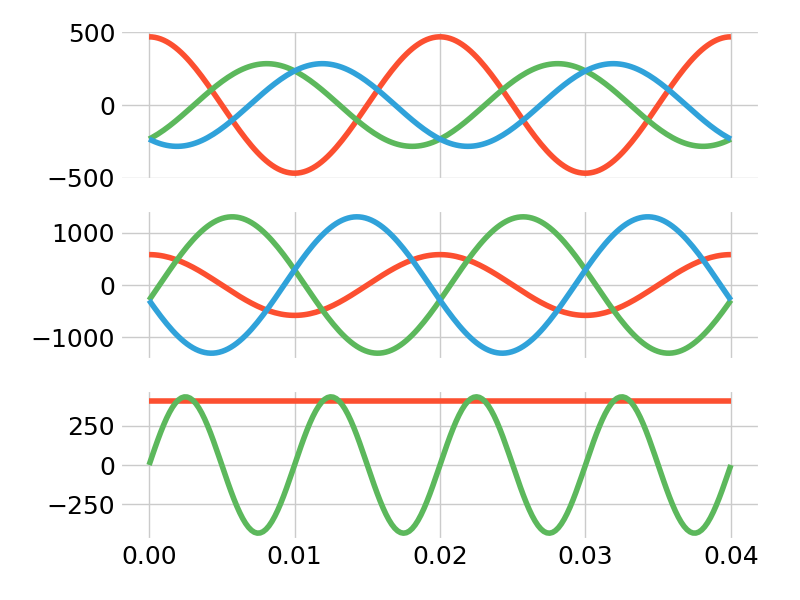

In [145]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex = True)

axes[0].plot(t, v_abc[0,:])
axes[0].plot(t, v_abc[1,:])
axes[0].plot(t, v_abc[2,:])

axes[1].plot(t, i_abc[0,:])
axes[1].plot(t, i_abc[1,:])
axes[1].plot(t, i_abc[2,:])

axes[2].plot(t, p/1000)
axes[2].plot(t, q/1000)

In [146]:
3*V_pos*I_pos

(500000+0j)

In [147]:
3*V_neg*I_neg

(-93701.392402691112+0j)

In [148]:
s_012 = 3*V_pos*I_pos + 3*V_neg*I_neg

In [149]:
s_012

(406298.60759730887+0j)

In [150]:
sin_012 = 3*V_pos*I_neg + 3*V_neg*I_pos 
cos_012 = 3*V_pos*I_neg - 3*V_neg*I_pos

In [151]:
print(sin_012,cos_012)

(-2.91038304567e-11+0j) (-432900.4329+0j)


In [152]:
s_012,sin_012,cos_012,V_pos,I_pos,V_neg,I_neg = sym.symbols('s_012,sin_012,cos_012,V_pos,I_pos,V_neg,I_neg ')

sin_012_ = 3*V_pos*I_neg + 3*V_neg*I_pos 
cos_012_ = 3*V_pos*I_neg - 3*V_neg*I_pos

eq1 = -s_012 + 3*V_pos*I_pos + 3*V_neg*I_neg
eq2 = sin_012-sin_012_ - cos_012+cos_012_
sym.solve([eq1,eq2],[I_pos,I_neg])

{I_neg: (2*V_neg*s_012 + V_pos*(cos_012 - sin_012))/(6*V_neg**2),
 I_pos: -(cos_012 - sin_012)/(6*V_neg)}

In [ ]:
I_pos

## Control Fisix

In [758]:
from sympy.functions import re,im

v_d_p,v_q_p,v_d_n,v_q_n,i_d_p,i_q_p,i_d_n,i_q_n,wt = sym.symbols('v_d_p,v_q_p,v_d_n,v_q_n,i_d_p,i_q_p,i_d_n,i_q_n,wt',real=True)
p_ref,q_ref = sym.symbols('p_ref,q_ref',real=True)

exp_p = sym.cos( wt)+1j*sym.sin( wt)
exp_n = sym.cos(-wt)+1j*sym.sin(-wt)

v_dq_p = v_q_p + 1j*v_d_p
v_dq_n = v_q_n + 1j*v_d_n
i_dq_p = i_q_p + 1j*i_d_p
i_dq_n = i_q_n + 1j*i_d_n

s = 3/2*(v_dq_p*exp_p + v_dq_n*exp_n)*sym.conjugate(i_dq_p*exp_p + i_dq_n*exp_n)
s = sym.simplify(sym.factor(sym.expand(s)))


In [759]:
p = sym.collect(re(s),[sym.cos(2*wt),sym.sin(2*wt)])
q = sym.collect(im(s),[sym.cos(2*wt),sym.sin(2*wt)])

In [760]:
p_cos = p.diff(sym.cos(2*wt))
p_sin = p.diff(sym.sin(2*wt))
p_cte = sym.simplify(p - p_cos*sym.cos(2*wt) - p_sin*sym.sin(2*wt))
q_cos = q.diff(sym.cos(2*wt))
q_sin = q.diff(sym.sin(2*wt))
q_cte = sym.simplify(q - q_cos*sym.cos(2*wt) - q_sin*sym.sin(2*wt))

In [761]:
lhs = ['p_cte','p_cos','p_sin','q_cte','q_cos','q_sin']
rhs = [p_cte,p_cos,p_sin,q_cte,q_cos,q_sin]
for lh,rh in zip(lhs,rhs):
    print('{:s}_ref = {:s}'.format(str(lh) ,str(sym.simplify(rh))))

p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref = 1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n
q_cte_ref = -1.5*i_d_n*v_q_n - 1.5*i_d_p*v_q_p + 1.5*i_q_n*v_d_n + 1.5*i_q_p*v_d_p
q_cos_ref = -1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p - 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p - 1.5*i_q_p*v_q_n


### References for p constant

In [762]:
sol = sym.solve([p_cte-p_ref,q_cte-q_ref,p_cos,p_sin],[i_d_p,i_q_p,i_d_n,i_q_n])
for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s}_ref = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

i_d_p_ref = -(0.666666666666667*p_ref*v_d_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + 0.666666666666667*q_ref*v_q_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
i_q_p_ref = 0.666666666666667*(-p_ref*v_q_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + q_ref*v_d_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
i_d_n_ref = 0.666666666666667*(p_ref*v_d_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) - q_ref*v_q_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
i_q_n_ref = 0.666666666666667*(p_ref*v_q_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + q_ref*v_d_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)


### References for q constant

In [763]:
sol = sym.solve([p_cte-p_ref,q_cte-q_ref,q_cos,q_sin],[i_d_p,i_q_p,i_d_n,i_q_n])
for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s}_ref = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

i_d_p_ref = 0.666666666666667*(p_ref*v_d_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) + q_ref*v_q_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
i_q_p_ref = 0.666666666666667*(p_ref*v_q_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) - q_ref*v_d_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
i_d_n_ref = 0.666666666666667*(p_ref*v_d_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) - q_ref*v_q_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
i_q_n_ref = 0.666666666666667*(p_ref*v_q_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) + q_ref*v_d_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)


### References for p and q constant

In [ ]:
sol = sym.solve([p_cte-p_ref,q_cte-q_ref,p_cos,q_sin],[i_d_p,i_q_p,i_d_n,i_q_n])
for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s}_ref = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

In [ ]:
sym.simplify(p_cos-q_sin)

In [ ]:
sym.simplify(p_sin-q_cos)

### Lipo

In [136]:
import sympy as sym
from sympy.functions import re,im

v_d_p,v_q_p,v_d_n,v_q_n,i_d_p,i_q_p,i_d_n,i_q_n,wt = sym.symbols('v_d_p,v_q_p,v_d_n,v_q_n,i_d_p,i_q_p,i_d_n,i_q_n,wt',real=True)
p_ref,q_ref = sym.symbols('p_ref,q_ref',real=True)

exp_p = sym.cos( wt)+1j*sym.sin( wt)
exp_n = sym.cos(-wt)+1j*sym.sin(-wt)

v_dq_p = v_d_p + 1j*v_q_p
v_dq_n = v_d_n + 1j*v_q_n
i_dq_p = i_d_p + 1j*i_q_p
i_dq_n = i_d_n + 1j*i_q_n

s = 3/2*(exp_p*v_dq_p + exp_n*v_dq_n)*sym.conjugate(exp_p*i_dq_p + exp_n*i_dq_n)
s = sym.simplify(sym.factor(sym.expand(s)))

t = 3/2*(-1j*exp_p*v_dq_p + 1j*exp_n*v_dq_n)*sym.conjugate(exp_p*i_dq_p + exp_n*i_dq_n)
t = sym.simplify(sym.factor(sym.expand(t)))

p = sym.collect(re(s),[sym.cos(2*wt),sym.sin(2*wt)])
q = sym.collect(re(t),[sym.cos(2*wt),sym.sin(2*wt)])

p_cos = p.diff(sym.cos(2*wt))
p_sin = p.diff(sym.sin(2*wt))
p_cte = sym.simplify(p - p_cos*sym.cos(2*wt) - p_sin*sym.sin(2*wt))
q_cos = q.diff(sym.cos(2*wt))
q_sin = q.diff(sym.sin(2*wt))
q_cte = sym.simplify(q - q_cos*sym.cos(2*wt) - q_sin*sym.sin(2*wt))

lhs = ['p_cte','p_cos','p_sin','q_cte','q_cos','q_sin']
rhs = [p_cte,p_cos,p_sin,q_cte,q_cos,q_sin]
for lh,rh in zip(lhs,rhs):
    print('{:s}_ref = {:s}'.format(str(lh) ,str(sym.simplify(rh))))

p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref = -1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_cte_ref = -1.5*i_d_n*v_q_n + 1.5*i_d_p*v_q_p + 1.5*i_q_n*v_d_n - 1.5*i_q_p*v_d_p
q_cos_ref = 1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n


In [137]:
p

1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p + (1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n)*cos(2*wt) + (-1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n)*sin(2*wt)

In [199]:
sol = sym.solve([p_cte-p_ref,q_cte-q_ref,p_cos,p_sin],[i_d_p,i_q_p,i_d_n,i_q_n])
for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s}_ref = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

i_d_p_ref = -(0.666666666666667*p_ref*v_d_p + 0.666666666666667*q_ref*v_q_p)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
i_q_p_ref = 0.666666666666667*(-p_ref*v_q_p + q_ref*v_d_p)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
i_d_n_ref = 0.666666666666667*(p_ref*v_d_n - q_ref*v_q_n)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
i_q_n_ref = 0.666666666666667*(p_ref*v_q_n + q_ref*v_d_n)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)


In [200]:
q

-1.5*i_d_n*v_q_n + 1.5*i_d_p*v_q_p + 1.5*i_q_n*v_d_n - 1.5*i_q_p*v_d_p + (1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n)*sin(2*wt) + (1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n)*cos(2*wt)

In [201]:
p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref = -1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_cte_ref = -1.5*i_d_n*v_q_n + 1.5*i_d_p*v_q_p + 1.5*i_q_n*v_d_n - 1.5*i_q_p*v_d_p
q_cos_ref = 1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n

In [603]:
## Lipo con dq según fisix

In [1]:
import sympy as sym
from sympy.functions import re,im

v_d_p,v_q_p,v_d_n,v_q_n,i_d_p,i_q_p,i_d_n,i_q_n,wt = sym.symbols('v_d_p,v_q_p,v_d_n,v_q_n,i_d_p,i_q_p,i_d_n,i_q_n,wt',real=True)
p_ref,q_ref = sym.symbols('p_ref,q_ref',real=True)

exp_p = sym.cos( wt)+1j*sym.sin( wt)
exp_n = sym.cos(-wt)+1j*sym.sin(-wt)

v_dq_p = v_q_p + 1j*v_d_p
v_dq_n = v_q_n + 1j*v_d_n
i_dq_p = i_q_p + 1j*i_d_p
i_dq_n = i_q_n + 1j*i_d_n

s = 3/2*(exp_p*v_dq_p + exp_n*v_dq_n)*sym.conjugate(exp_p*i_dq_p + exp_n*i_dq_n)
s = sym.simplify(sym.factor(sym.expand(s)))

t = 3/2*(-1j*exp_p*v_dq_p + 1j*exp_n*v_dq_n)*sym.conjugate(exp_p*i_dq_p + exp_n*i_dq_n)
t = sym.simplify(sym.factor(sym.expand(t)))

p = sym.collect(re(s),[sym.cos(2*wt),sym.sin(2*wt)])
q = sym.collect(re(t),[sym.cos(2*wt),sym.sin(2*wt)])

p_cos = p.diff(sym.cos(2*wt))
p_sin = p.diff(sym.sin(2*wt))
p_cte = sym.simplify(p - p_cos*sym.cos(2*wt) - p_sin*sym.sin(2*wt))
q_cos = q.diff(sym.cos(2*wt))
q_sin = q.diff(sym.sin(2*wt))
q_cte = sym.simplify(q - q_cos*sym.cos(2*wt) - q_sin*sym.sin(2*wt))

lhs = ['p_cte','p_cos','p_sin','q_cte','q_cos','q_sin']
rhs = [p_cte,p_cos,p_sin,q_cte,q_cos,q_sin]
for lh,rh in zip(lhs,rhs):
    print('{:s}_ref = {:s}'.format(str(lh) ,str(sym.simplify(rh))))

p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref = 1.5*i_d_n*v_q_p - 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p + 1.5*i_q_p*v_d_n
q_cte_ref = 1.5*i_d_n*v_q_n - 1.5*i_d_p*v_q_p - 1.5*i_q_n*v_d_n + 1.5*i_q_p*v_d_p
q_cos_ref = -1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n


In [2]:
sol = sym.solve([p_cte-p_ref,q_cte-q_ref,p_cos,p_sin],[i_d_p,i_q_p,i_d_n,i_q_n])
for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s}_ref = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

i_d_p_ref = 0.666666666666667*(-p_ref*v_d_p + q_ref*v_q_p)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
i_q_p_ref = -(0.666666666666667*p_ref*v_q_p + 0.666666666666667*q_ref*v_d_p)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
i_d_n_ref = 0.666666666666667*(p_ref*v_d_n + q_ref*v_q_n)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)
i_q_n_ref = 0.666666666666667*(p_ref*v_q_n - q_ref*v_d_n)/(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2)


In [16]:

Clark = sym.Matrix([[1.0/sym.sqrt(2.0),1.0/sym.sqrt(2.0),1.0/sym.sqrt(2.0)],[1.0,-1.0/2.0,-1.0/2.0],[0,-sym.sqrt(3.0)/2.0,sym.sqrt(3.0)/2.0]])

In [24]:
import numpy as np
Clark = 2/3*np.array([[1/np.sqrt(2),  1/np.sqrt(2),1/np.sqrt(2)],
                      [            1,         -0.5,        -0.5],
                      [            0,-np.sqrt(3)/2,np.sqrt(3)/2]])
inv_Clark = np.linalg.inv(Clark)

In [4]:
pasar al tiempo con seq. pos y neg

SyntaxError: invalid syntax (<ipython-input-4-3ef08c724592>, line 1)

In [25]:
inv_Clark

array([[  7.07106781e-01,   1.00000000e+00,   2.40370336e-17],
       [  7.07106781e-01,  -5.00000000e-01,  -8.66025404e-01],
       [  7.07106781e-01,  -5.00000000e-01,   8.66025404e-01]])